# Most Streamed Spotify Songs 2023
 This project is based on "Most Streamed Spotify Songs 2023" dataset from Kaggle : https://www.kaggle.com/datasets/nelgiriyewithana/top-spotify-songs-2023
    

## What is this project about?
Here, the goal of this project is to build a model that predicts the target variable "streams" based on the given features.

# 1. Data

## 1.1. Split data

Before investigating the dataset, I want to split it into train and test since this project's goal is to building a prediction model.

In [289]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [290]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [291]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/for_data/spotify_2023.csv', encoding='utf-8')

But before splitting, let's deal with some missing values first.

In [292]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    object
 9   in_apple_playlists    953 non-null    int64 
 10  in_apple_charts       953 non-null    int64 
 11  in_deezer_playlists   953 non-null    object
 12  in_deezer_charts      953 non-null    int64 
 13  in_shazam_charts      903 non-null    object
 14  bpm                   953 non-null    int64 
 15  key                   858 non-null    ob

There are 50 missing values in 'in_shazam_charts' attribute, and 95 missing values in 'key' attribute.   
Clearly, 'key' is categorical variable. However, 'in_shazam_charts', 'in_deezer_playlists' and 'streams' seem like they're supposed to be numerical, but the output above describe it's type as 'object'.   
Lets see why.


In [293]:
print("investigating 'in_shazam_charts' attribute:")
print(df['in_shazam_charts'].unique())
print()
print("investigating 'in_deezer_playlists' attribute:")
print(df['in_deezer_playlists'].unique())
print()
print("investigating 'streams' attribute:")
print(df['streams'].unique())

investigating 'in_shazam_charts' attribute:
['826' '382' '949' '548' '425' '946' '418' '194' '953' '339' '251' '168'
 '1,021' '1,281' nan '187' '0' '1,173' '29' '150' '73' '139' '1,093' '96'
 '211' '325' '294' '197' '27' '310' '354' '184' '212' '81' '82' '100' '62'
 '69' '727' '311' '1,133' '102' '332' '259' '140' '16' '110' '810' '176'
 '615' '210' '216' '215' '167' '37' '171' '272' '529' '26' '5' '169' '230'
 '84' '154' '93' '115' '72' '8' '323' '49' '1,451' '1,170' '429' '162'
 '10' '478' '236' '200' '78' '266' '486' '204' '34' '202' '312' '32' '153'
 '519' '458' '48' '666' '14' '925' '88' '203' '44' '74' '638' '64' '71'
 '2' '3' '136' '148' '22' '368' '1' '189' '52' '9' '31' '66' '208' '28'
 '558' '195' '13' '60' '503' '56' '15' '454' '40' '285' '129' '58' '117'
 '47' '20' '30' '80' '263' '116' '57' '39' '111' '7' '166' '19' '99' '51'
 '109' '42' '33' '675' '348' '36' '240' '113' '6' '23' '4' '182' '54'
 '438' '11' '17' '50' '320' '55' '18' '38' '43' '105' '24' '63' '444' '85'
 '21

Attribues are actually numeric, but since the datum is stored surrounded by single quotes (') and including commas(,) they appear as object type.
   
Also, there is a 'NaN' in the target feature. I think it came from misreading CSV. I should just get rid of it.

In [294]:
#drop the NaN value from 'streams'
df = df[df['streams'] != 'BPM110KeyAModeMajorDanceability53Valence75Energy69Acousticness7Instrumentalness0Liveness17Speechiness3']

#strip single quotes in 'streams' and change the type as numeric.
df['streams'] = df['streams'].astype(str).str.replace("'", "")
df['streams'] = pd.to_numeric(df['streams'], errors='coerce')

In [295]:
#strip single quotes in 'in_shazam_charts' and change the type as numeric.
df['in_shazam_charts'] = df['in_shazam_charts'].astype(str).str.replace("'", "")
df['in_shazam_charts'] = pd.to_numeric(df['in_shazam_charts'], errors='coerce')

In [296]:
#strip single quotes and commas in 'in_deezer_playlists' and change the type as numeric.
df['in_deezer_playlists'] = (
    df['in_deezer_playlists']
      .astype(str)
      .str.replace(r"[',]", "", regex=True)
)
df['in_deezer_playlists'] = pd.to_numeric(df['in_deezer_playlists'], errors='coerce')

Now I can really say how I could deal with the missing values.    
With 'in_shazam_charts', I will replace the missing values with the mean of the values. With 'key' attribute, let's just fill missing values with a new category, 'unknown'.

In [297]:
#fill NAs with mean value for 'in_shazam_charts'
shazam_mean_value = df['in_shazam_charts'].mean()
df['in_shazam_charts'] = df['in_shazam_charts'].fillna(shazam_mean_value)

#fill NAs with 'unknown' for 'key'
df['key'] = df['key'].fillna('unknown')

In [298]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 952 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   track_name            952 non-null    object 
 1   artist(s)_name        952 non-null    object 
 2   artist_count          952 non-null    int64  
 3   released_year         952 non-null    int64  
 4   released_month        952 non-null    int64  
 5   released_day          952 non-null    int64  
 6   in_spotify_playlists  952 non-null    int64  
 7   in_spotify_charts     952 non-null    int64  
 8   streams               952 non-null    int64  
 9   in_apple_playlists    952 non-null    int64  
 10  in_apple_charts       952 non-null    int64  
 11  in_deezer_playlists   952 non-null    int64  
 12  in_deezer_charts      952 non-null    int64  
 13  in_shazam_charts      952 non-null    float64
 14  bpm                   952 non-null    int64  
 15  key                   952 no

In [299]:
print(df['in_shazam_charts'].unique())
print(df['in_deezer_playlists'].unique())

[826.         382.         949.         548.         425.
 946.         418.         194.         953.         339.
 251.         168.          51.23351955 187.           0.
  29.         150.          73.         139.          96.
 211.         325.         294.         197.          27.
 310.         354.         184.         212.          81.
  82.         100.          62.          69.         727.
 311.         102.         332.         259.         140.
  16.         110.         810.         176.         615.
 210.         216.         215.         167.          37.
 171.         272.         529.          26.           5.
 169.         230.          84.         154.          93.
 115.          72.           8.         323.          49.
 429.         162.          10.         478.         236.
 200.          78.         266.         486.         204.
  34.         202.         312.          32.         153.
 519.         458.          48.         666.          14.
 925.         

Now the dataset looks good. Finally I can split it.

In [300]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

## 1.2. Look around the dataset
<br>
Now let's look through the columns of our dataset, and then briefly examine how they're distributed.

In [301]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 761 entries, 318 to 102
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   track_name            761 non-null    object 
 1   artist(s)_name        761 non-null    object 
 2   artist_count          761 non-null    int64  
 3   released_year         761 non-null    int64  
 4   released_month        761 non-null    int64  
 5   released_day          761 non-null    int64  
 6   in_spotify_playlists  761 non-null    int64  
 7   in_spotify_charts     761 non-null    int64  
 8   streams               761 non-null    int64  
 9   in_apple_playlists    761 non-null    int64  
 10  in_apple_charts       761 non-null    int64  
 11  in_deezer_playlists   761 non-null    int64  
 12  in_deezer_charts      761 non-null    int64  
 13  in_shazam_charts      761 non-null    float64
 14  bpm                   761 non-null    int64  
 15  key                   761 

There are 761 rows for training.

In [302]:
train_df.head(10)

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
318,Malas Decisiones,Kenia OS,1,2022,10,26,542,2,156214700,23,...,110,G#,Minor,81,64,79,5,0,31,3
545,Softcore,The Neighbourhood,1,2018,3,9,3947,12,599770206,33,...,94,D,Major,57,36,58,5,0,15,3
557,Lï¿½ï¿½ï¿,Stromae,1,2022,1,9,2035,0,108809090,41,...,88,D,Minor,56,58,55,35,0,23,11
109,Set Fire to the Rain,Adele,1,2011,1,1,14739,43,1163620694,88,...,108,D,Minor,61,47,68,0,0,13,3
77,Unholy (feat. Kim Petras),"Sam Smith, Kim Petras",2,2022,9,22,8576,42,1230675890,216,...,131,D,Major,71,24,47,1,0,27,9
606,Pope Is a Rockstar,SALES,1,2016,4,20,1966,0,156658366,4,...,90,E,Minor,73,31,45,85,24,11,3
880,Baile no Morro,"Mc Vitin Da Igrejinha, MC Tairon, DJ Win",3,2022,6,10,685,2,129314708,17,...,130,D#,Minor,71,78,40,46,0,7,45
82,Novidade na ï¿½ï¿,"Mc Livinho, DJ Matt D",2,2023,6,23,267,9,39709092,9,...,130,F,Major,63,36,34,76,0,35,9
894,"Stay With Me (with Justin Timberlake, Halsey, ...","Calvin Harris, Halsey, Pharrell Williams, Just...",4,2022,7,15,3113,0,123473120,54,...,126,A,Major,81,90,73,28,0,29,4
359,Zona De Perigo,Leo Santana,1,2022,12,8,531,4,134294498,20,...,135,F,Major,81,97,77,75,0,35,3


Each row in this dataset represents a song, with 24 columns providing various attributes for each track.

In [303]:
train_df.columns

Index(['track_name', 'artist(s)_name', 'artist_count', 'released_year',
       'released_month', 'released_day', 'in_spotify_playlists',
       'in_spotify_charts', 'streams', 'in_apple_playlists', 'in_apple_charts',
       'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts', 'bpm',
       'key', 'mode', 'danceability_%', 'valence_%', 'energy_%',
       'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%'],
      dtype='object')

From the code above, we can see there's 24 columns, and they are:

**track_name**: Name of the song    
**artist(s)_name**: Name of the artist(s) of the song   
**artist_count**: Number of artists contributing to the song      
**released_year**: Year when the song was released  
**released_month**: Month when the song was released  
**released_day**: Day of the month when the song was released  
**in_spotify_playlists**: Number of Spotify playlists the song is included i  
**in_spotify_charts**: Presence and rank of the song on Spotify charts   
**streams**: Total number of streams on Spotify  
**in_apple_playlists**: Number of Apple Music playlists the song is included in  
**in_apple_charts**: Presence and rank of the song on Apple Music charts  
**in_deezer_playlists**: Number of Deezer playlists the song is included in  
**in_deezer_charts**: Presence and rank of the song on Deezer charts   
**in_shazam_charts**: Presence and rank of the song on Shazam charts  
**bpm**: Beats per minute, a measure of song tempo  
**key**: Key of the song  
**mode**: Mode of the song (major or minor)  
**danceability_%**: Percentage indicating how suitable the song is for dancing  
**valence_%**: Positivity of the song's musical content   
**energy_%**: Perceived energy level of the song  
**acousticness_%**: Amount of acoustic sound in the song  
**instrumentalness_%**: Amount of instrumental content in the song  
**liveness_%**: Presence of live performance elements       
**speechiness_%**: Amount of spoken words in the song        
<br>

**track_name**, **artist(s)_name**, **key**, **mode** are categorical. The others are numeric.

Now, lets just simply look at the distribution of each features.

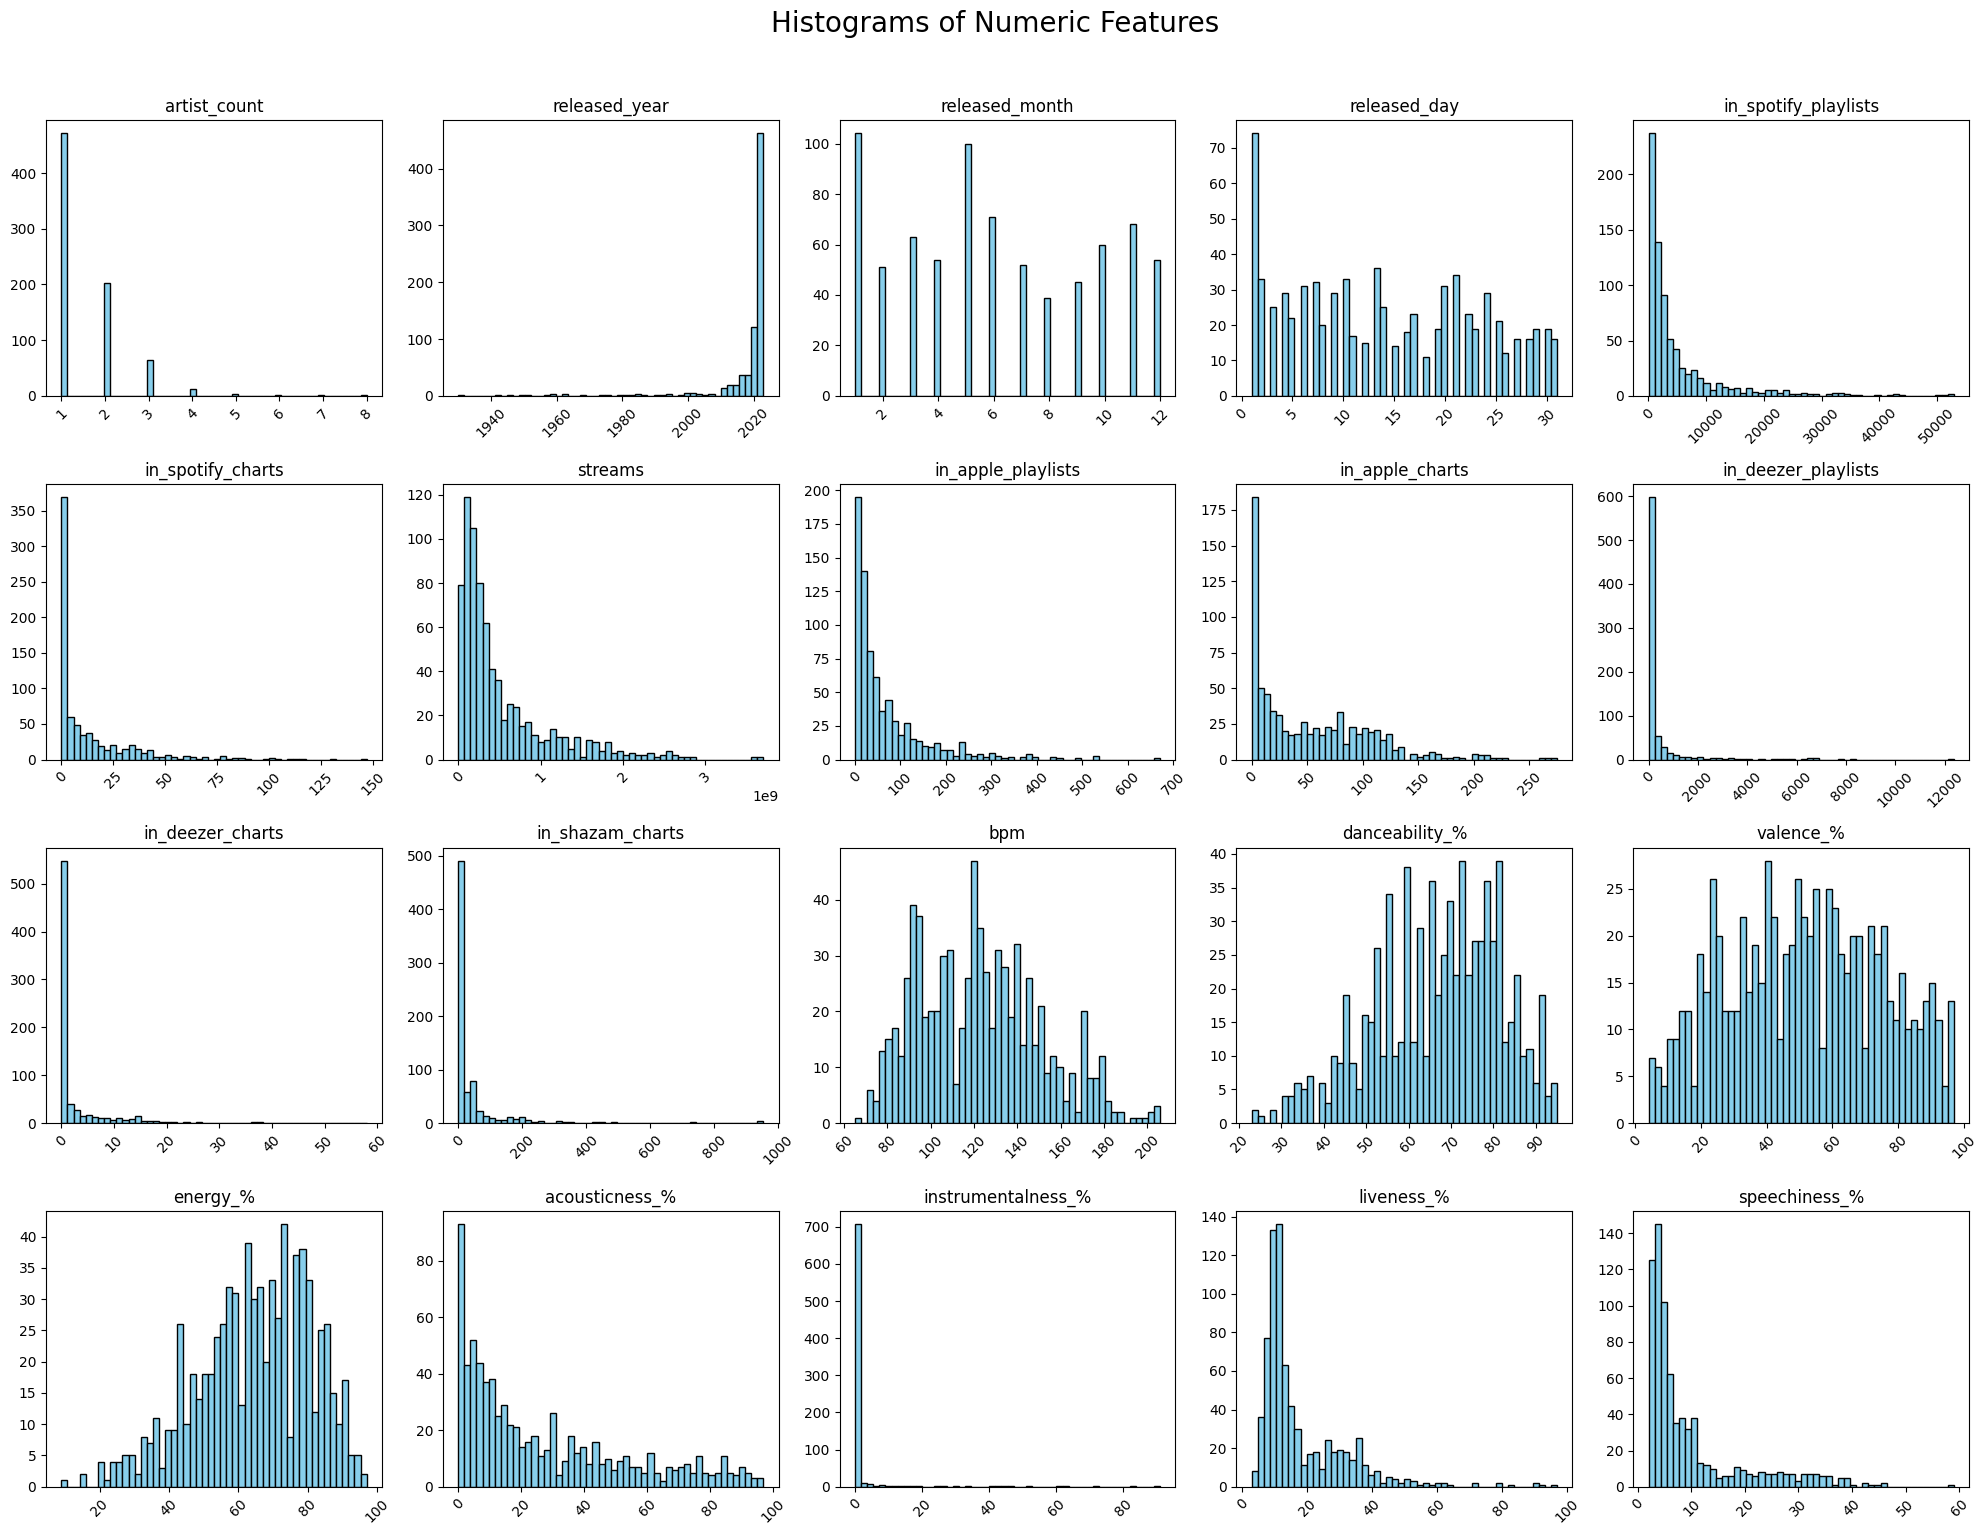

In [304]:
#Histograms of Numeric Features
numeric_cols = train_df.select_dtypes(include=['number']).columns.tolist()
numerics = train_df[numeric_cols]

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 15))
fig.suptitle('Histograms of Numeric Features', fontsize=20, y=1.02)

for ax, col in zip(axes.flatten(), numeric_cols):
    ax.hist(numerics[col], bins=50, color='skyblue', edgecolor='black')
    ax.set_title(col, fontsize=12)
    ax.tick_params(axis='x', rotation=45)  # rotating labels of x axes

# just for the future reusability
for ax in axes.flatten()[len(numeric_cols):]:
    ax.set_visible(False)

#showing plots
plt.tight_layout()
plt.show()


In [305]:
train_df.describe()

,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,in_shazam_charts,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
count,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,7.610000e+02,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000
mean,1.553219,2018.307490,6.063075,13.852825,5304.517740,12.612352,5.247383e+08,68.375821,51.808147,392.367937,2.787122,51.699048,122.638633,66.947438,51.557162,64.357424,27.118265,1.626807,18.061761,9.940867
std,0.904735,11.109506,3.537947,9.193212,8035.734262,20.506438,5.830953e+08,89.018349,51.635667,1147.861614,6.319718,128.112665,28.099579,14.724930,23.441859,16.541049,26.323577,8.728659,13.612209,9.548239
min,1.000000,1930.000000,1.000000,1.000000,31.000000,0.000000,2.762000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,65.000000,23.000000,4.000000,9.000000,0.000000,0.000000,3.000000,2.000000
25%,1.000000,2020.000000,3.000000,6.000000,873.000000,0.000000,1.445652e+08,13.000000,6.000000,13.000000,0.000000,0.000000,99.000000,56.000000,33.000000,53.000000,6.000000,0.000000,10.000000,4.000000
50%,1.000000,2022.000000,6.000000,13.000000,2209.000000,3.000000,2.943521e+08,34.000000,38.000000,44.000000,0.000000,4.000000,121.000000,69.000000,52.000000,66.000000,17.000000,0.000000,12.000000,6.000000
75%,2.000000,2022.000000,9.000000,21.000000,5897.000000,17.000000,6.824752e+08,85.000000,87.000000,181.000000,2.000000,51.000000,140.000000,78.000000,70.000000,77.000000,43.000000,0.000000,23.000000,11.000000
max,8.000000,2023.000000,12.000000,31.000000,52898.000000,147.000000,3.703895e+09,672.000000,275.000000,12367.000000,58.000000,953.000000,206.000000,95.000000,97.000000,97.000000,97.000000,91.000000,97.000000,59.000000


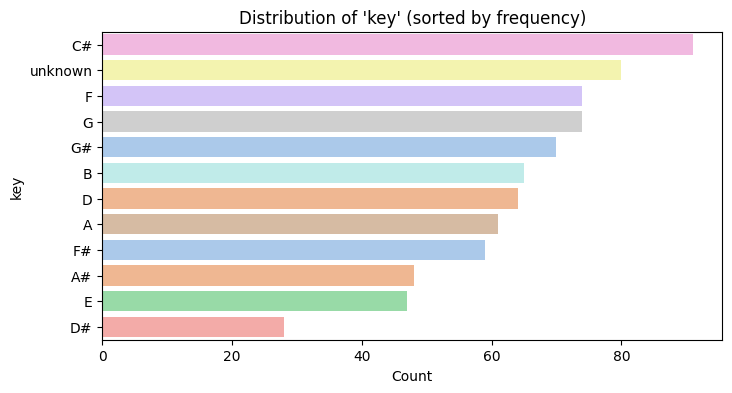

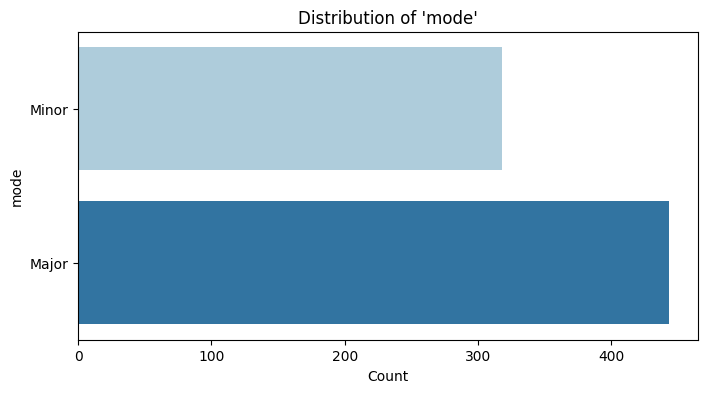

In [306]:
#Distribution of two categorical features
# Distribution of 'key' (sorted by frequency)
plt.figure(figsize=(8, 4))
sns.countplot(y='key',
              data=train_df,
              hue='key',
              palette='pastel',
              order=train_df['key'].value_counts().index,
              legend=False)
plt.title("Distribution of 'key' (sorted by frequency)")
plt.ylabel('key')
plt.xlabel('Count')
plt.show()

# Distribution of 'mode'
plt.figure(figsize=(8, 4))
sns.countplot(y='mode', data=train_df, hue='mode', palette='Paired', legend=False)
plt.title("Distribution of 'mode'")
plt.ylabel('mode')
plt.xlabel('Count')
plt.show()


**Summary:**

**artist_count**: Most songs have only one artist, and the count decreases exponentially for more artists.

**released_year**: The majority of songs were released very recently.

**released_month**: January and May see the highest number of song releases, while August has the fewest.

**released_day**: The 1st day of each month has a disproportionately high number of releases; on other days, the distribution is relatively even. There's a cyclical pattern where the count peaks every third day and then drops.

**in_spotify_playlists**, **in_apple_playlists**, **in_deezer_playlists**: The distributions are heavily skewed toward zero, especially for Deezer. Spotify shows a long right tail, and Apple is only slightly less skewed than Spotify.

**in_spotify_charts**, **in_apple_charts**, **in_deezer_charts**, **in_shazam_charts**: All are strongly skewed toward zero. Spotify, Deezer, and Shazam have very similar distributions, but Apple shows a relatively even spread around the median compared to the others.

**bpm**: Values around 120 are the most frequent, with many around the low 90s as well. Overall, the distribution is right-skewed with sporadic spikes—likely because artists intentionally target specific BPMs.

**danceability_%**: Mostly left-skewed, with noticeable spikes at certain points.

**valence_%**: Generally follows a thick-tailed normal distribution, and also shows pronounced spikes.

**energy_%**: Also left-skewed, but contains fewer spikes than other characteristics.

**acousticness_%**: The distribution slopes downward from left to right—higher values on the left, tapering off toward the right.

**instrumentalness_%**: The vast majority of values are zero, with non-zero values being very sparse.

**liveness_%**: Most data is concentrated on the lower end, left of the median.

**speechness_%**: Similar to liveness_%, but with slightly less skew.

**key**: C# is the most common key, followed by “unknown;” D# is the least common. There’s more than a threefold difference between the most and least frequent keys.

**mode**: Major is more frequently observed than minor.

## 1.3. Finding Outliers and High Leverage Points

### 1.3.1 Drawing Boxplots
Let's start from drawing boxplots.

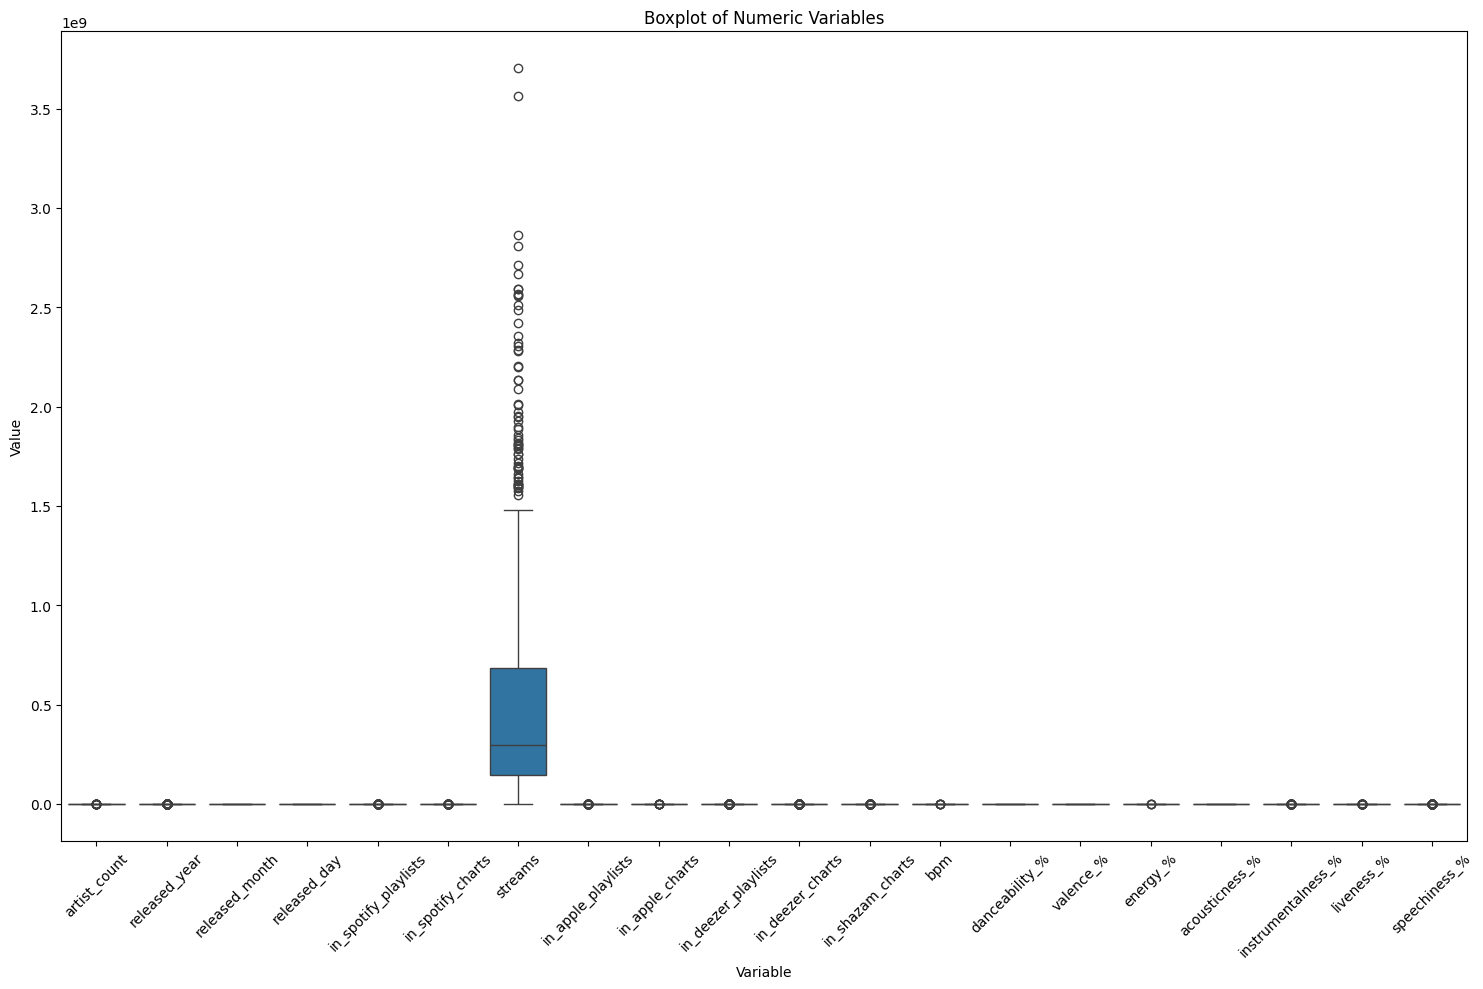

In [307]:
melted_df = numerics.melt(var_name='Variable', value_name='Value')

plt.figure(figsize=(15, 10))
sns.boxplot(x='Variable', y='Value', data=melted_df)
plt.xticks(rotation=45)
plt.title('Boxplot of Numeric Variables')
plt.tight_layout()
plt.show()

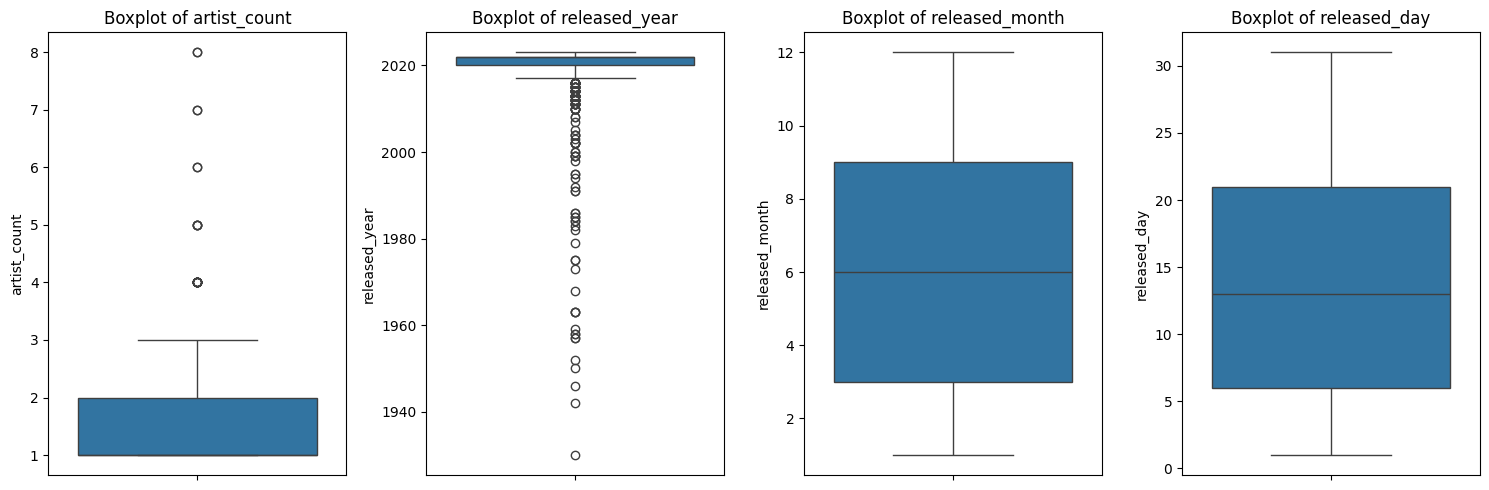

,artist_count,released_year,released_month,released_day
count,761.000000,761.000000,761.000000,761.000000
mean,1.553219,2018.307490,6.063075,13.852825
std,0.904735,11.109506,3.537947,9.193212
min,1.000000,1930.000000,1.000000,1.000000
25%,1.000000,2020.000000,3.000000,6.000000
50%,1.000000,2022.000000,6.000000,13.000000
75%,2.000000,2022.000000,9.000000,21.000000
max,8.000000,2023.000000,12.000000,31.000000


In [308]:
# 'artist_count', 'released_year', 'released_month', 'released_day'

vars_to_plot = ['artist_count', 'released_year', 'released_month', 'released_day']

plt.figure(figsize=(15, 5))
for i, var in enumerate(vars_to_plot):
    plt.subplot(1, 4, i + 1)
    sns.boxplot(y=train_df[var])
    plt.title(f'Boxplot of {var}')
    plt.ylabel(var)
plt.tight_layout()
plt.show()

train_df[vars_to_plot].describe()

Although the boxplots display some points as outliers, there do not appear to be any values in these variables that are significant enough to be considered true outliers.

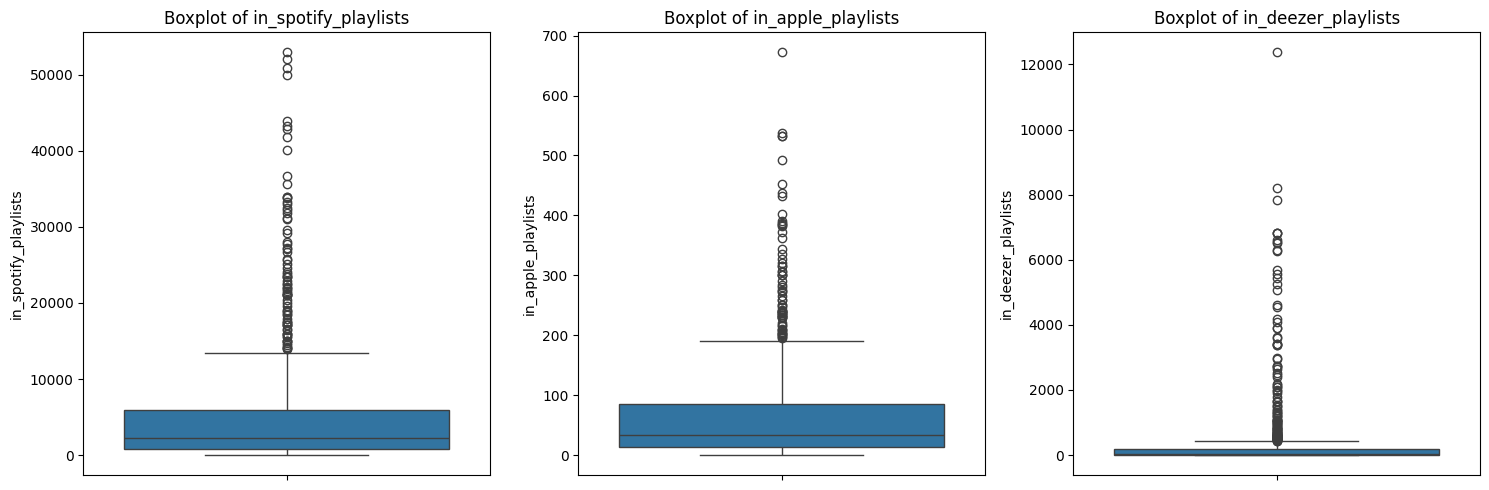

,in_spotify_playlists,in_apple_playlists,in_deezer_playlists
count,761.000000,761.000000,761.000000
mean,5304.517740,68.375821,392.367937
std,8035.734262,89.018349,1147.861614
min,31.000000,0.000000,0.000000
25%,873.000000,13.000000,13.000000
50%,2209.000000,34.000000,44.000000
75%,5897.000000,85.000000,181.000000
max,52898.000000,672.000000,12367.000000


In [309]:
# 'in_spotify_playlists', 'in_apple_playlists', 'in_deezer_playlists'

vars_to_plot = ['in_spotify_playlists', 'in_apple_playlists', 'in_deezer_playlists']

plt.figure(figsize=(15, 5))
for i, var in enumerate(vars_to_plot):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(y=train_df[var])
    plt.title(f'Boxplot of {var}')
    plt.ylabel(var)
plt.tight_layout()
plt.show()

train_df[vars_to_plot].describe()

I think it’s worth investigating this further here. Some data points have unusually high values, so let’s focus on those. If a song is popular, the high observations in all three variables might correspond to the same data point. I’ll print the number of IQR-based outliers for each of the three variables, and then identify the data points that are outliers in all three variables.

In [310]:
def get_iqr_outliers(df, column):
    """
    A function that returns only the rows with IQR-based outliers
    for the specified column in the input DataFrame df
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outlier_df = df[(df[column] < lower) | (df[column] > upper)]
    return outlier_df


In [311]:
spotify_playlists_iqr_outliers = get_iqr_outliers(train_df, 'in_spotify_playlists')
apple_playlists_iqr_outliers = get_iqr_outliers(train_df, 'in_apple_playlists')
deezer_playlists_iqr_outliers = get_iqr_outliers(train_df, 'in_deezer_playlists')

In [312]:
spotify_playlists_iqr_outliers.sort_values('in_spotify_playlists', ascending=False)[['track_name','in_spotify_playlists', 'in_apple_playlists', 'in_deezer_playlists']]

,track_name,in_spotify_playlists,in_apple_playlists,in_deezer_playlists
757,Get Lucky - Radio Edit,52898,203,8215
630,Mr. Brightside,51979,306,5063
720,Wake Me Up - Radio Edit,50887,315,6284
624,Smells Like Teen Spirit - Remastered 2021,49991,265,12367
55,Blinding Lights,43899,672,3421
...,...,...,...,...
571,Leave The Door Open,14417,237,569
462,Do They Know It's Christmas? - 1984 Version,14169,209,449
440,Payphone,14143,56,1891
554,Peaches (feat. Daniel Caesar & Giveon),14140,231,612


In [313]:
apple_playlists_iqr_outliers.sort_values('in_apple_playlists', ascending=False)[['track_name','in_spotify_playlists', 'in_apple_playlists', 'in_deezer_playlists']]

,track_name,in_spotify_playlists,in_apple_playlists,in_deezer_playlists
55,Blinding Lights,43899,672,3421
403,One Kiss (with Dua Lipa),27705,537,2726
620,Dance Monkey,24529,533,3595
407,Don't Start Now,27119,532,1535
84,STAY (with Justin Bieber),17050,492,798
...,...,...,...,...
434,Woman,9424,202,463
126,Can't Hold Us (feat. Ray Dalton),6074,201,6551
433,Levitating (feat. DaBaby),15894,198,544
164,Save Your Tears,12688,197,112


In [314]:
deezer_playlists_iqr_outliers.sort_values('in_deezer_playlists', ascending=False)[['track_name','in_spotify_playlists', 'in_apple_playlists', 'in_deezer_playlists']]

,track_name,in_spotify_playlists,in_apple_playlists,in_deezer_playlists
624,Smells Like Teen Spirit - Remastered 2021,49991,265,12367
757,Get Lucky - Radio Edit,52898,203,8215
910,The Scientist,30992,124,7827
358,In The End,25065,63,6808
179,Shape of You,32181,33,6808
...,...,...,...,...
46,I Ain't Worried,8431,241,458
161,Gasolina,6457,98,453
462,Do They Know It's Christmas? - 1984 Version,14169,209,449
446,Santa Tell Me,9408,231,439


In [315]:
def get_multi_iqr_outliers(df, columns):
    """
    Returns rows that are IQR outliers for all specified columns.
    columns: list of column names
    """
    mask = np.ones(len(df), dtype=bool)
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        mask &= ((df[col] < lower) | (df[col] > upper)).to_numpy()
    return df[mask]

In [316]:
cols = ['in_spotify_playlists', 'in_apple_playlists', 'in_deezer_playlists']

#get IQR outliers for all three columns
multi_outliers_df = get_multi_iqr_outliers(train_df, cols)
multi_outliers_df[['track_name','in_spotify_playlists', 'in_apple_playlists', 'in_deezer_playlists']]

,track_name,in_spotify_playlists,in_apple_playlists,in_deezer_playlists
54,Another Love,18371,250,3394
84,STAY (with Justin Bieber),17050,492,798
513,good 4 u,15563,259,461
516,Kiss Me More (feat. SZA),15867,382,497
55,Blinding Lights,43899,672,3421
630,Mr. Brightside,51979,306,5063
296,Lose Yourself - Soundtrack Version,32502,247,5567
685,Thinking Out Loud,33032,363,3895
433,Levitating (feat. DaBaby),15894,198,544
140,Believer,18986,250,2969


As expected, many songs turned out to be outliers in all three variables based on the IQR method. However, a large number of these songs are actually quite popular, so it seems that determining outliers solely using the IQR approach is not appropriate. Let’s consider using more sophisticated methods for outlier detection in the future.

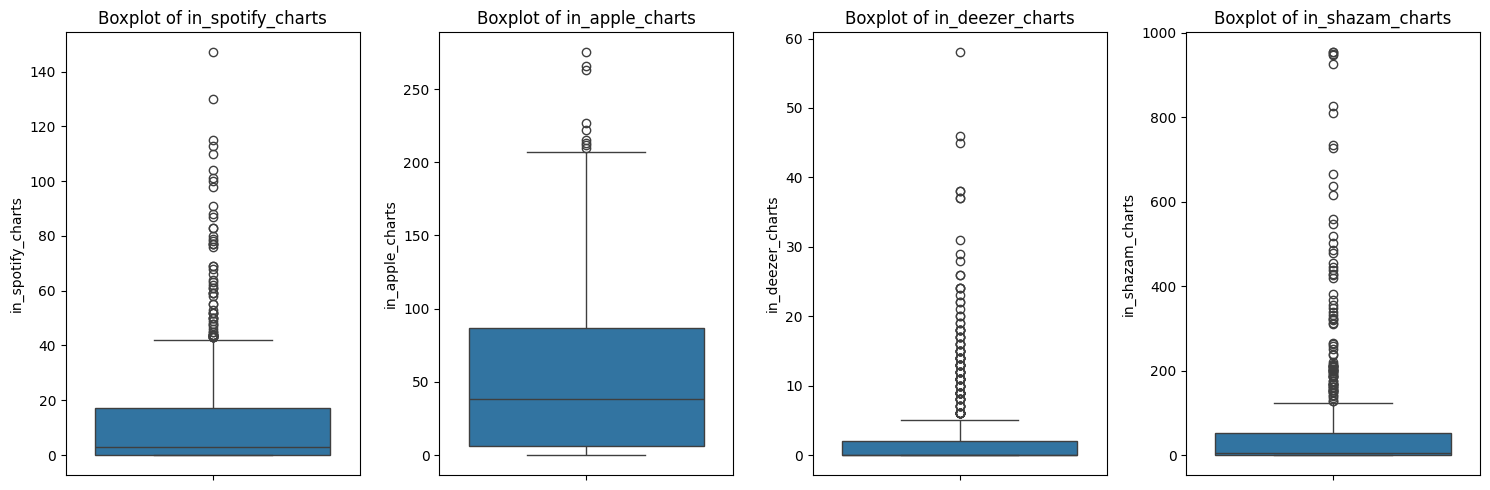

,in_spotify_charts,in_apple_charts,in_deezer_charts,in_shazam_charts
count,761.000000,761.000000,761.000000,761.000000
mean,12.612352,51.808147,2.787122,51.699048
std,20.506438,51.635667,6.319718,128.112665
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,6.000000,0.000000,0.000000
50%,3.000000,38.000000,0.000000,4.000000
75%,17.000000,87.000000,2.000000,51.000000
max,147.000000,275.000000,58.000000,953.000000


In [317]:
# 'in_spotify_charts', 'in_apple_charts', 'in_deezer_charts', 'in_shazam_charts'

vars_to_plot = ['in_spotify_charts', 'in_apple_charts', 'in_deezer_charts', 'in_shazam_charts']

plt.figure(figsize=(15, 5))
for i, var in enumerate(vars_to_plot):
    plt.subplot(1, 4, i + 1)
    sns.boxplot(y=train_df[var])
    plt.title(f'Boxplot of {var}')
    plt.ylabel(var)
plt.tight_layout()
plt.show()

train_df[vars_to_plot].describe()

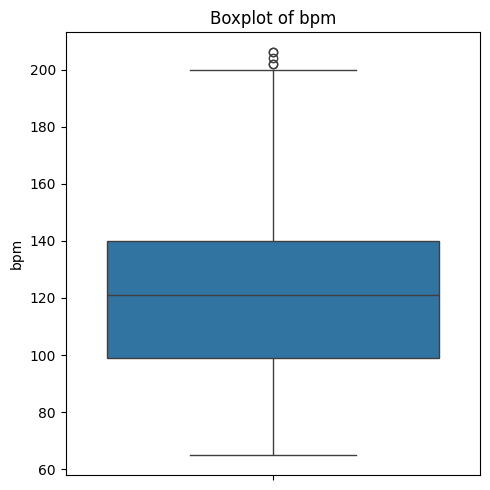

,bpm
count,761.000000
mean,122.638633
std,28.099579
min,65.000000
25%,99.000000
50%,121.000000
75%,140.000000
max,206.000000


In [318]:
# 'bpm'

vars_to_plot = ['bpm']

plt.figure(figsize=(5, 5))
for i, var in enumerate(vars_to_plot):
    plt.subplot(1, 1, i + 1)
    sns.boxplot(y=train_df[var])
    plt.title(f'Boxplot of {var}')
    plt.ylabel(var)
plt.tight_layout()
plt.show()

train_df[vars_to_plot].describe()

In [319]:
get_iqr_outliers(train_df, 'bpm')

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
506,We Don't Talk About Bruno,"Adassa, Mauro Castillo, Stephanie Beatriz, Enc...",7,2021,11,19,2785,0,432719968,95,...,206,unknown,Minor,58,83,45,36,0,11,8
244,Until I Found You,Stephen Sanchez,1,2021,9,1,4427,4,726434358,69,...,202,A#,Major,34,25,51,69,0,18,4
28,Last Night,Morgan Wallen,1,2023,1,31,2420,19,429829812,52,...,204,F#,Major,52,52,68,46,0,15,4
447,It's the Most Wonderful Time of the Year,Andy Williams,1,1963,10,14,8879,0,663832097,182,...,202,G,Major,24,76,60,77,0,12,4
100,Lover,Taylor Swift,1,2012,1,1,8448,23,882831184,160,...,206,G,Major,43,50,55,50,0,15,10


There are only 5 outliers based on the IQR method, and even those values are quite plausible.

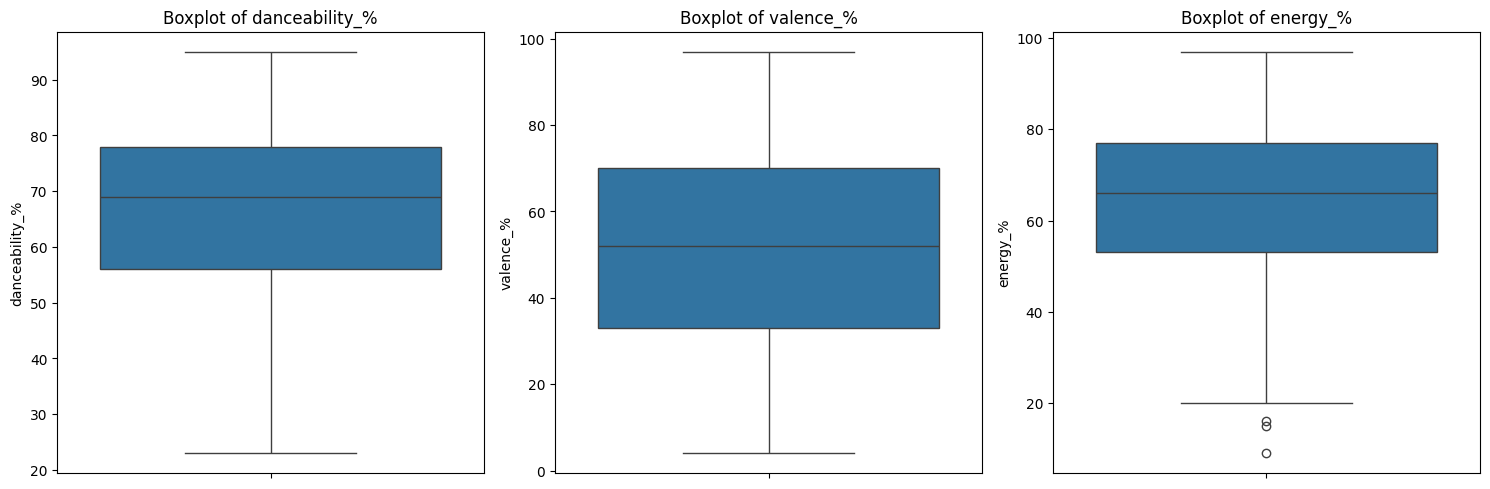

,danceability_%,valence_%,energy_%
count,761.000000,761.000000,761.000000
mean,66.947438,51.557162,64.357424
std,14.724930,23.441859,16.541049
min,23.000000,4.000000,9.000000
25%,56.000000,33.000000,53.000000
50%,69.000000,52.000000,66.000000
75%,78.000000,70.000000,77.000000
max,95.000000,97.000000,97.000000


In [320]:
# 'danceability_%', 'valence_%', 'energy_%'

vars_to_plot = ['danceability_%', 'valence_%', 'energy_%']

plt.figure(figsize=(15, 5))
for i, var in enumerate(vars_to_plot):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(y=train_df[var])
    plt.title(f'Boxplot of {var}')
    plt.ylabel(var)
plt.tight_layout()
plt.show()

train_df[vars_to_plot].describe()

In [321]:
get_iqr_outliers(train_df, 'energy_%')

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
17,What Was I Made For? [From The Motion Picture ...,Billie Eilish,1,2023,7,13,873,104,30546883,80,...,78,unknown,Major,44,14,9,96,0,10,3
940,Sweet Nothing,Taylor Swift,1,2022,10,21,1747,0,186104310,9,...,177,unknown,Major,34,39,16,97,0,12,5
460,The Christmas Song (Merry Christmas To You) - ...,Nat King Cole,1,1946,11,1,11500,0,389771964,140,...,139,C#,Major,36,22,15,84,0,11,4


There are three outliers in the 'energy_%' variable based on the IQR method, but in reality, all three songs are simply low-energy tracks. Although it’s unclear how the 'energy_%' value was calculated, none of these songs seem to pose a significant issue.



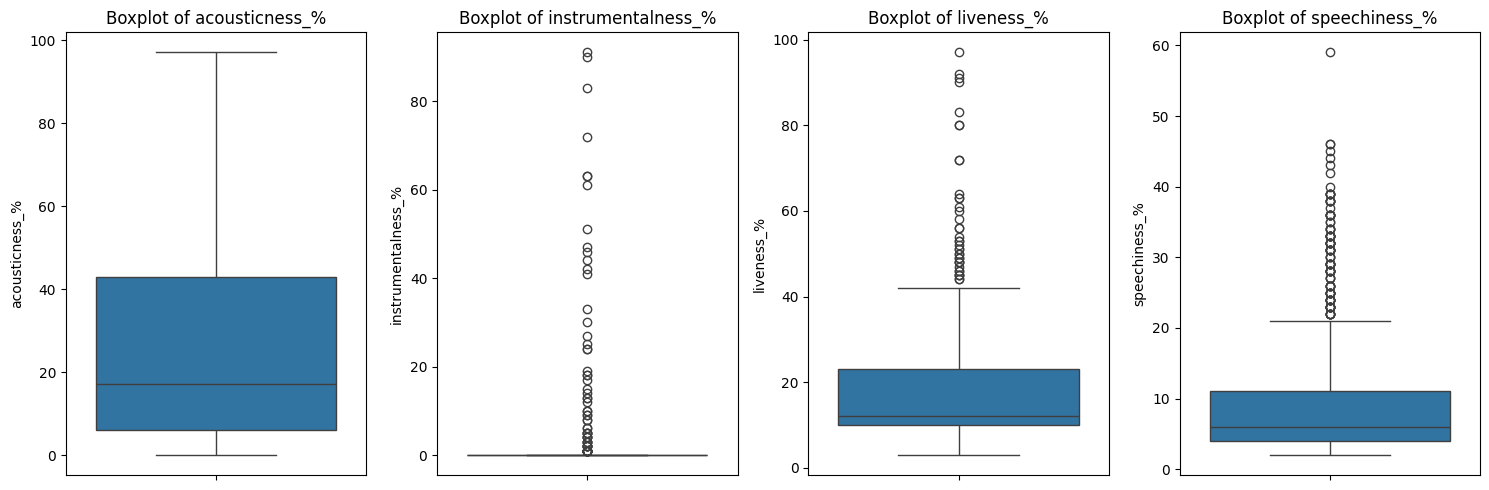

,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
count,761.000000,761.000000,761.000000,761.000000
mean,27.118265,1.626807,18.061761,9.940867
std,26.323577,8.728659,13.612209,9.548239
min,0.000000,0.000000,3.000000,2.000000
25%,6.000000,0.000000,10.000000,4.000000
50%,17.000000,0.000000,12.000000,6.000000
75%,43.000000,0.000000,23.000000,11.000000
max,97.000000,91.000000,97.000000,59.000000


In [322]:
# 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%'

vars_to_plot = ['acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']

plt.figure(figsize=(15, 5))
for i, var in enumerate(vars_to_plot):
    plt.subplot(1, 4, i + 1)
    sns.boxplot(y=train_df[var])
    plt.title(f'Boxplot of {var}')
    plt.ylabel(var)
plt.tight_layout()
plt.show()

train_df[vars_to_plot].describe()

The most noticeable point is that the distribution of 'instrumentalness_%' is heavily skewed towards the lower end.    
The distribution of 'acousticness_%' doesn’t seem to have any issues.    
For 'liveness_%' and 'speechiness_%', the distributions are somewhat skewed—though not as much as 'instrumentalness_%'.    
I plan to print the IQR outliers for each variable. Also, since one outlier in 'speechiness_%' appears to stand out with a particularly high value, I’d like to take a closer look at that specific data point.

In [323]:
inst_iqr_outliers = get_iqr_outliers(train_df, 'instrumentalness_%')
inst_iqr_outliers.sort_values('instrumentalness_%', ascending=False)[['track_name','instrumentalness_%']]

,track_name,instrumentalness_%
684,Alien Blues,91
284,METAMORPHOSIS,90
917,Poland,83
691,Forever,72
579,Freaks,63
...,...,...
85,El Merengue,1
563,pushin P (feat. Young Thug),1
856,SLOW DANCING IN THE DARK,1
389,"Sex, Drugs, Etc.",1


Instrumentalness indicates the extent to which a song contains no vocals, and tracks with high scores that appear as outliers were often actually instrumental. Given that the mean of 'instrumentalness_%' is 1.627, it seems that most of the songs in the dataset contain vocals.

In [324]:
live_iqr_outliers = get_iqr_outliers(train_df, 'liveness_%')
live_iqr_outliers.sort_values('liveness_%', ascending=False)[['track_name','liveness_%']]

,track_name,liveness_%
601,Vai Lï¿½ï¿½ Em Casa,97
367,Bombonzinho - Ao Vivo,92
229,Seu Brilho Sumiu - Ao Vivo,91
688,Mal Feito - Ao Vivo,90
94,Still With You,83
240,Erro Gostoso - Ao Vivo,80
249,Oi Balde - Ao Vivo,80
432,Good Days,72
409,Eu Gosto Assim - Ao Vivo,72
167,The Night We Met,64


38 outliers.   
Many of the top tracks with high 'liveness_%' are labeled 'Ao Vivo', such as 'Bombonzinho - Ao Vivo', and 'Ao Vivo' means 'live' in Portuguese. This shows that the upper IQR outliers in the dataset are, in fact, perfectly reasonable data points.

In [325]:
speech_iqr_outliers= get_iqr_outliers(train_df, 'speechiness_%')
speech_iqr_outliers.sort_values('speechiness_%', ascending=False)[['track_name', 'artist(s)_name', 'speechiness_%']]

,track_name,artist(s)_name,speechiness_%
935,On BS,"Drake, 21 Savage",59
780,Savior,"Kendrick Lamar, Sam Dew, Baby Keem",46
426,Limbo,Freddie Dredd,46
880,Baile no Morro,"Mc Vitin Da Igrejinha, MC Tairon, DJ Win",45
930,Casei Com a Putaria,"MC Ryan SP, Love Funk, Mc Paiva ZS",44
...,...,...,...
594,Sobrio,Maluma,22
175,Reminder,The Weeknd,22
524,THATS WHAT I WANT,Lil Nas X,22
241,Cupido,Tini,22


Most of the IQR outliers with high 'speechiness_%' were hip-hop tracks, including the one with the highest score, 'On BS'. There do not appear to be any concerning outliers for this variable either.

### 1.3.2 DBSCAN
Now let's use DBSCAN to find some significant outliers.

In [326]:
#log transformation for skewed features
train_copy = train_df.copy()
for col in ['in_spotify_playlists','in_spotify_charts', 'streams',
            'in_apple_playlists', 'in_apple_charts', 'in_deezer_playlists',
            'in_deezer_charts', 'in_shazam_charts', 'acousticness_%',
            'instrumentalness_%', 'liveness_%', 'speechiness_%']:
    train_copy[col + '_log'] = np.log1p(train_copy[col])

In [327]:
#Scale data using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

subject_df = train_copy.drop(columns=[
            'in_spotify_playlists','in_spotify_charts', 'streams',
            'in_apple_playlists', 'in_apple_charts', 'in_deezer_playlists',
            'in_deezer_charts', 'in_shazam_charts', 'acousticness_%',
            'instrumentalness_%', 'liveness_%', 'speechiness_%',
            'track_name', 'artist(s)_name', 'key', 'mode'])

scaler = MinMaxScaler()
normalized = scaler.fit_transform(subject_df)
normalized_train = pd.DataFrame(normalized, columns=subject_df.columns)

In [328]:
normalized_train.describe()

,artist_count,released_year,released_month,released_day,bpm,danceability_%,valence_%,energy_%,in_spotify_playlists_log,in_spotify_charts_log,streams_log,in_apple_playlists_log,in_apple_charts_log,in_deezer_playlists_log,in_deezer_charts_log,in_shazam_charts_log,acousticness_%_log,instrumentalness_%_log,liveness_%_log,speechiness_%_log
count,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.0000,761.000000,761.000000
mean,0.079031,0.949543,0.460280,0.428428,0.408785,0.610381,0.511367,0.629062,0.574668,0.306591,0.821353,0.535433,0.553915,0.424821,0.164649,0.296742,0.594095,0.0444,0.429506,0.341759
std,0.129248,0.119457,0.321632,0.306440,0.199288,0.204513,0.252063,0.187966,0.181851,0.305497,0.083439,0.207634,0.292031,0.205430,0.240082,0.293851,0.279500,0.1624,0.182270,0.227313
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
25%,0.000000,0.967742,0.181818,0.166667,0.241135,0.458333,0.311828,0.500000,0.446311,0.000000,0.770111,0.405276,0.346223,0.280069,0.000000,0.000000,0.424411,0.0000,0.316256,0.170518
50%,0.000000,0.989247,0.454545,0.400000,0.397163,0.638889,0.516129,0.647727,0.571495,0.277414,0.820509,0.545990,0.651833,0.403981,0.000000,0.234589,0.630402,0.0000,0.368482,0.282835
75%,0.142857,0.989247,0.727273,0.666667,0.531915,0.763889,0.709677,0.772727,0.703961,0.578397,0.880114,0.684048,0.796622,0.552274,0.269430,0.575927,0.825347,0.0000,0.560157,0.462756
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000,1.000000


In [329]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

X = normalized_train.values

eps_list = np.arange(0.1, 2.1, 0.1)   # grid searching for eps and min_samples
min_samples_list = [3, 5, 10, 20]

for eps in eps_list:
    for ms in min_samples_list:
        cluster = DBSCAN(eps=eps, min_samples=ms)
        labels = cluster.fit_predict(X)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        score = silhouette_score(X, labels) if len(set(labels)) > 1 else None
        if score is not None:
          print(f"eps={eps:.1f}, min_samples={ms} → cluster={n_clusters}, noise={n_noise}, silhouette_score={score:.3f}")
        else:
          print(f"eps={eps:.1f}, min_samples={ms} → cluster={n_clusters}, noise={n_noise}, silhouette_score=None")

eps=0.1, min_samples=3 → cluster=0, noise=761, silhouette_score=None
eps=0.1, min_samples=5 → cluster=0, noise=761, silhouette_score=None
eps=0.1, min_samples=10 → cluster=0, noise=761, silhouette_score=None
eps=0.1, min_samples=20 → cluster=0, noise=761, silhouette_score=None
eps=0.2, min_samples=3 → cluster=0, noise=761, silhouette_score=None
eps=0.2, min_samples=5 → cluster=0, noise=761, silhouette_score=None
eps=0.2, min_samples=10 → cluster=0, noise=761, silhouette_score=None
eps=0.2, min_samples=20 → cluster=0, noise=761, silhouette_score=None
eps=0.3, min_samples=3 → cluster=0, noise=761, silhouette_score=None
eps=0.3, min_samples=5 → cluster=0, noise=761, silhouette_score=None
eps=0.3, min_samples=10 → cluster=0, noise=761, silhouette_score=None
eps=0.3, min_samples=20 → cluster=0, noise=761, silhouette_score=None
eps=0.4, min_samples=3 → cluster=2, noise=755, silhouette_score=-0.079
eps=0.4, min_samples=5 → cluster=0, noise=761, silhouette_score=None
eps=0.4, min_samples=10 → 

In [330]:
cluster = DBSCAN(eps=1.0, min_samples=10)
labels = cluster.fit_predict(X)

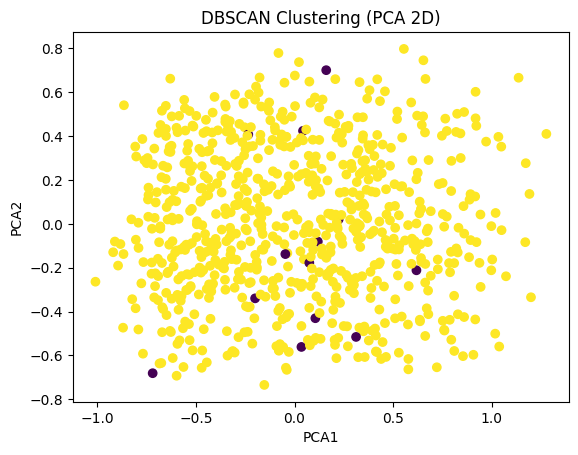

In [331]:
#visualize through PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o')
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("DBSCAN Clustering (PCA 2D)")
plt.show()

DBSCAN did not produce any meaningful clusters. The silhouette score was low, and for most parameter combinations, all data were classified as noise or only a single cluster was formed. I have decided to stop here, as I believe further outlier detection on this dataset would be meaningless.

## 1.4. Encoding Categorical Features

First, I decided not to encode the 'track_name' attribute. This is because it has a very large number of unique values and it is unlikely to be an important variable for prediction.   
Now, I'll think about 'artist(s)_name' attribute.
Obviously, there are many unique values.

In [332]:
train_df['artist(s)_name'].value_counts()

,count
artist(s)_name,
Taylor Swift,28
The Weeknd,19
SZA,15
Harry Styles,14
Bad Bunny,13
...,...
Lord Huron,1
"Brray, Rauw Alejandro, Lyanno",1
"Bebe Rexha, David Guetta",1


So, It is absurd to encode all of them. Instead, I could try encoding top N values and rest as 'others'.

In [333]:
train_df['artist(s)_name'].value_counts()[:50]

,count
artist(s)_name,
Taylor Swift,28
The Weeknd,19
SZA,15
Harry Styles,14
Bad Bunny,13
Kendrick Lamar,10
Morgan Wallen,10
Feid,7
BTS,7


Top 20 seems reasonable to me, so I'll try that.

In [334]:
top_n = 20
top_artists = train_df['artist(s)_name'].value_counts().index[:top_n]

train_df['artist_onehot'] = train_df['artist(s)_name'].apply(lambda x: x if x in top_artists else 'Others')

onehot_df = pd.get_dummies(train_df['artist_onehot'], prefix='artist')

In [335]:
onehot_df

,artist_Adele,artist_Arctic Monkeys,artist_BTS,artist_Bad Bunny,artist_Billie Eilish,artist_Bruno Mars,artist_Doja Cat,"artist_Drake, 21 Savage",artist_Ed Sheeran,artist_Feid,...,artist_Karol G,artist_Kendrick Lamar,artist_Labrinth,artist_Morgan Wallen,artist_Olivia Rodrigo,artist_Others,artist_Quevedo,artist_SZA,artist_Taylor Swift,artist_The Weeknd
318,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
545,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
557,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
109,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
77,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
270,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
861,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
435,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


Now let's deal with 'key' and 'mode'.

In [336]:
key_onehot = pd.get_dummies(train_df['key'], prefix='key')

In [337]:
key_onehot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 761 entries, 318 to 102
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   key_A        761 non-null    bool 
 1   key_A#       761 non-null    bool 
 2   key_B        761 non-null    bool 
 3   key_C#       761 non-null    bool 
 4   key_D        761 non-null    bool 
 5   key_D#       761 non-null    bool 
 6   key_E        761 non-null    bool 
 7   key_F        761 non-null    bool 
 8   key_F#       761 non-null    bool 
 9   key_G        761 non-null    bool 
 10  key_G#       761 non-null    bool 
 11  key_unknown  761 non-null    bool 
dtypes: bool(12)
memory usage: 14.9 KB


In [338]:
mode_onehot = pd.get_dummies(train_df['mode'], prefix='mode')

In [339]:
mode_onehot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 761 entries, 318 to 102
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   mode_Major  761 non-null    bool 
 1   mode_Minor  761 non-null    bool 
dtypes: bool(2)
memory usage: 7.4 KB


In [340]:
normalized_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   artist_count              761 non-null    float64
 1   released_year             761 non-null    float64
 2   released_month            761 non-null    float64
 3   released_day              761 non-null    float64
 4   bpm                       761 non-null    float64
 5   danceability_%            761 non-null    float64
 6   valence_%                 761 non-null    float64
 7   energy_%                  761 non-null    float64
 8   in_spotify_playlists_log  761 non-null    float64
 9   in_spotify_charts_log     761 non-null    float64
 10  streams_log               761 non-null    float64
 11  in_apple_playlists_log    761 non-null    float64
 12  in_apple_charts_log       761 non-null    float64
 13  in_deezer_playlists_log   761 non-null    float64
 14  in_deezer_

In [341]:
onehot_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 761 entries, 318 to 102
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   artist_Adele             761 non-null    bool 
 1   artist_Arctic Monkeys    761 non-null    bool 
 2   artist_BTS               761 non-null    bool 
 3   artist_Bad Bunny         761 non-null    bool 
 4   artist_Billie Eilish     761 non-null    bool 
 5   artist_Bruno Mars        761 non-null    bool 
 6   artist_Doja Cat          761 non-null    bool 
 7   artist_Drake, 21 Savage  761 non-null    bool 
 8   artist_Ed Sheeran        761 non-null    bool 
 9   artist_Feid              761 non-null    bool 
 10  artist_Harry Styles      761 non-null    bool 
 11  artist_Karol G           761 non-null    bool 
 12  artist_Kendrick Lamar    761 non-null    bool 
 13  artist_Labrinth          761 non-null    bool 
 14  artist_Morgan Wallen     761 non-null    bool 
 15  artist_Ol

In [342]:
dfs = [normalized_train, onehot_df, key_onehot, mode_onehot]
dfs = [df.reset_index(drop=True) for df in dfs]
train_df = pd.concat(dfs, axis=1)

In [343]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   artist_count              761 non-null    float64
 1   released_year             761 non-null    float64
 2   released_month            761 non-null    float64
 3   released_day              761 non-null    float64
 4   bpm                       761 non-null    float64
 5   danceability_%            761 non-null    float64
 6   valence_%                 761 non-null    float64
 7   energy_%                  761 non-null    float64
 8   in_spotify_playlists_log  761 non-null    float64
 9   in_spotify_charts_log     761 non-null    float64
 10  streams_log               761 non-null    float64
 11  in_apple_playlists_log    761 non-null    float64
 12  in_apple_charts_log       761 non-null    float64
 13  in_deezer_playlists_log   761 non-null    float64
 14  in_deezer_

In [344]:
train_df

,artist_count,released_year,released_month,released_day,bpm,danceability_%,valence_%,energy_%,in_spotify_playlists_log,in_spotify_charts_log,...,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,key_unknown,mode_Major,mode_Minor
0,0.000000,0.989247,0.818182,0.833333,0.319149,0.805556,0.645161,0.795455,0.382081,0.219845,...,False,False,False,False,False,False,True,False,False,True
1,0.000000,0.946237,0.181818,0.266667,0.205674,0.472222,0.344086,0.556818,0.649793,0.513276,...,True,False,False,False,False,False,False,False,True,False
2,0.000000,0.989247,0.000000,0.266667,0.163121,0.458333,0.580645,0.522727,0.560429,0.000000,...,True,False,False,False,False,False,False,False,False,True
3,0.000000,0.870968,0.000000,0.000000,0.304965,0.527778,0.462366,0.670455,0.827564,0.757260,...,True,False,False,False,False,False,False,False,False,True
4,0.142857,0.989247,0.727273,0.700000,0.468085,0.666667,0.215054,0.431818,0.754494,0.752660,...,True,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756,0.285714,0.935484,0.909091,0.300000,0.361702,0.791667,0.946237,0.806818,0.875957,0.794501,...,False,False,False,False,False,False,False,False,True,False
757,0.000000,0.956989,0.636364,0.733333,0.219858,0.680556,0.387097,0.431818,0.498113,0.389399,...,True,False,False,False,False,False,False,False,True,False
758,0.000000,0.989247,0.363636,0.400000,0.631206,0.652778,1.000000,0.602273,0.374937,0.000000,...,False,False,False,False,True,False,False,False,False,True
759,0.000000,0.989247,0.727273,0.433333,0.141844,0.583333,0.344086,0.431818,0.419025,0.416120,...,False,False,False,True,False,False,False,False,False,True


Now, all the columns are either numeric or boolean. So the encoding part is over. We now have 54 columns.

# 2. Building Models
   
Now lets build some prediction models from the data I prepared.

## 2.1. Linear Regression

### 2.1.2. Examine Linearity Between features
First of all, let's examine linearity between the target variable and the others.

In [345]:
def examine_linear(df, target_col, num_cols):
    variables = num_cols
    target = target_col

    fig, axes = plt.subplots(4, 5, figsize=(20, 16))
    axes = axes.flatten()

    for i, var in enumerate(variables):
        x = df[var]
        y = df[target]
        axes[i].scatter(x, y, alpha=0.7)

        # 추세선(1차 회귀직선) 계산 및 추가
        if x.nunique() > 1:  # 상수변수 방지
            m, b = np.polyfit(x, y, 1)
            axes[i].plot(x, m * x + b, color='red', linewidth=2)

        axes[i].set_title(f"{var} vs {target}")
        axes[i].set_xlabel(var)
        axes[i].set_ylabel(target)

    plt.tight_layout()
    plt.show()

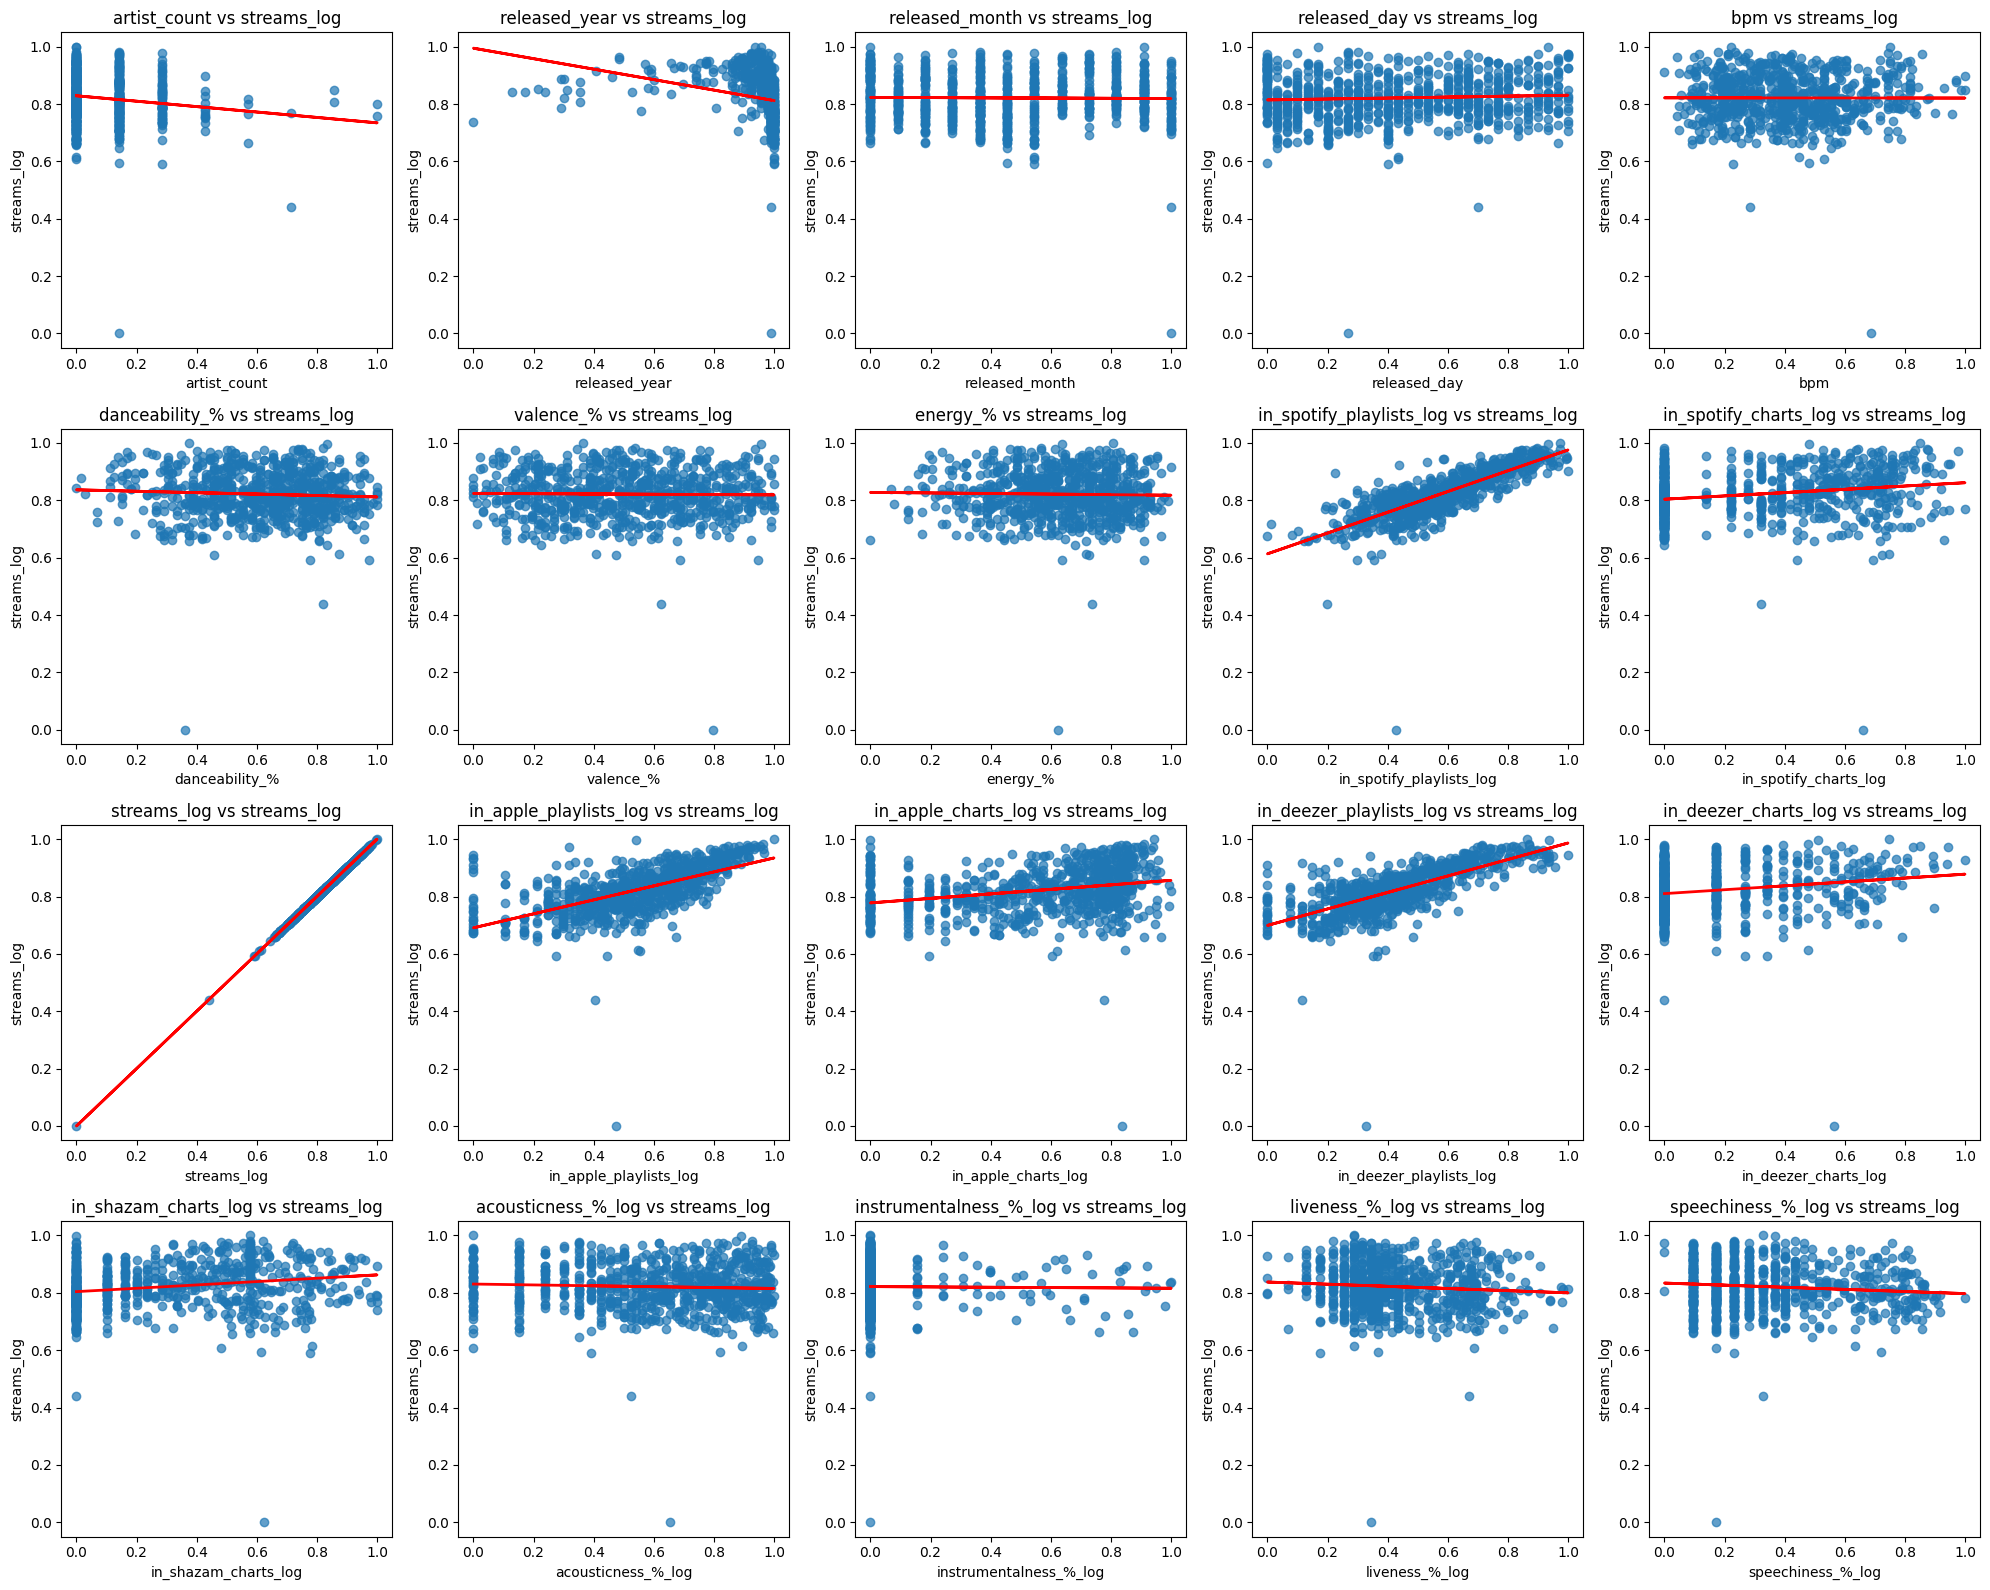

In [347]:
examine_linear(train_df, 'streams_log', train_df.columns[:20])

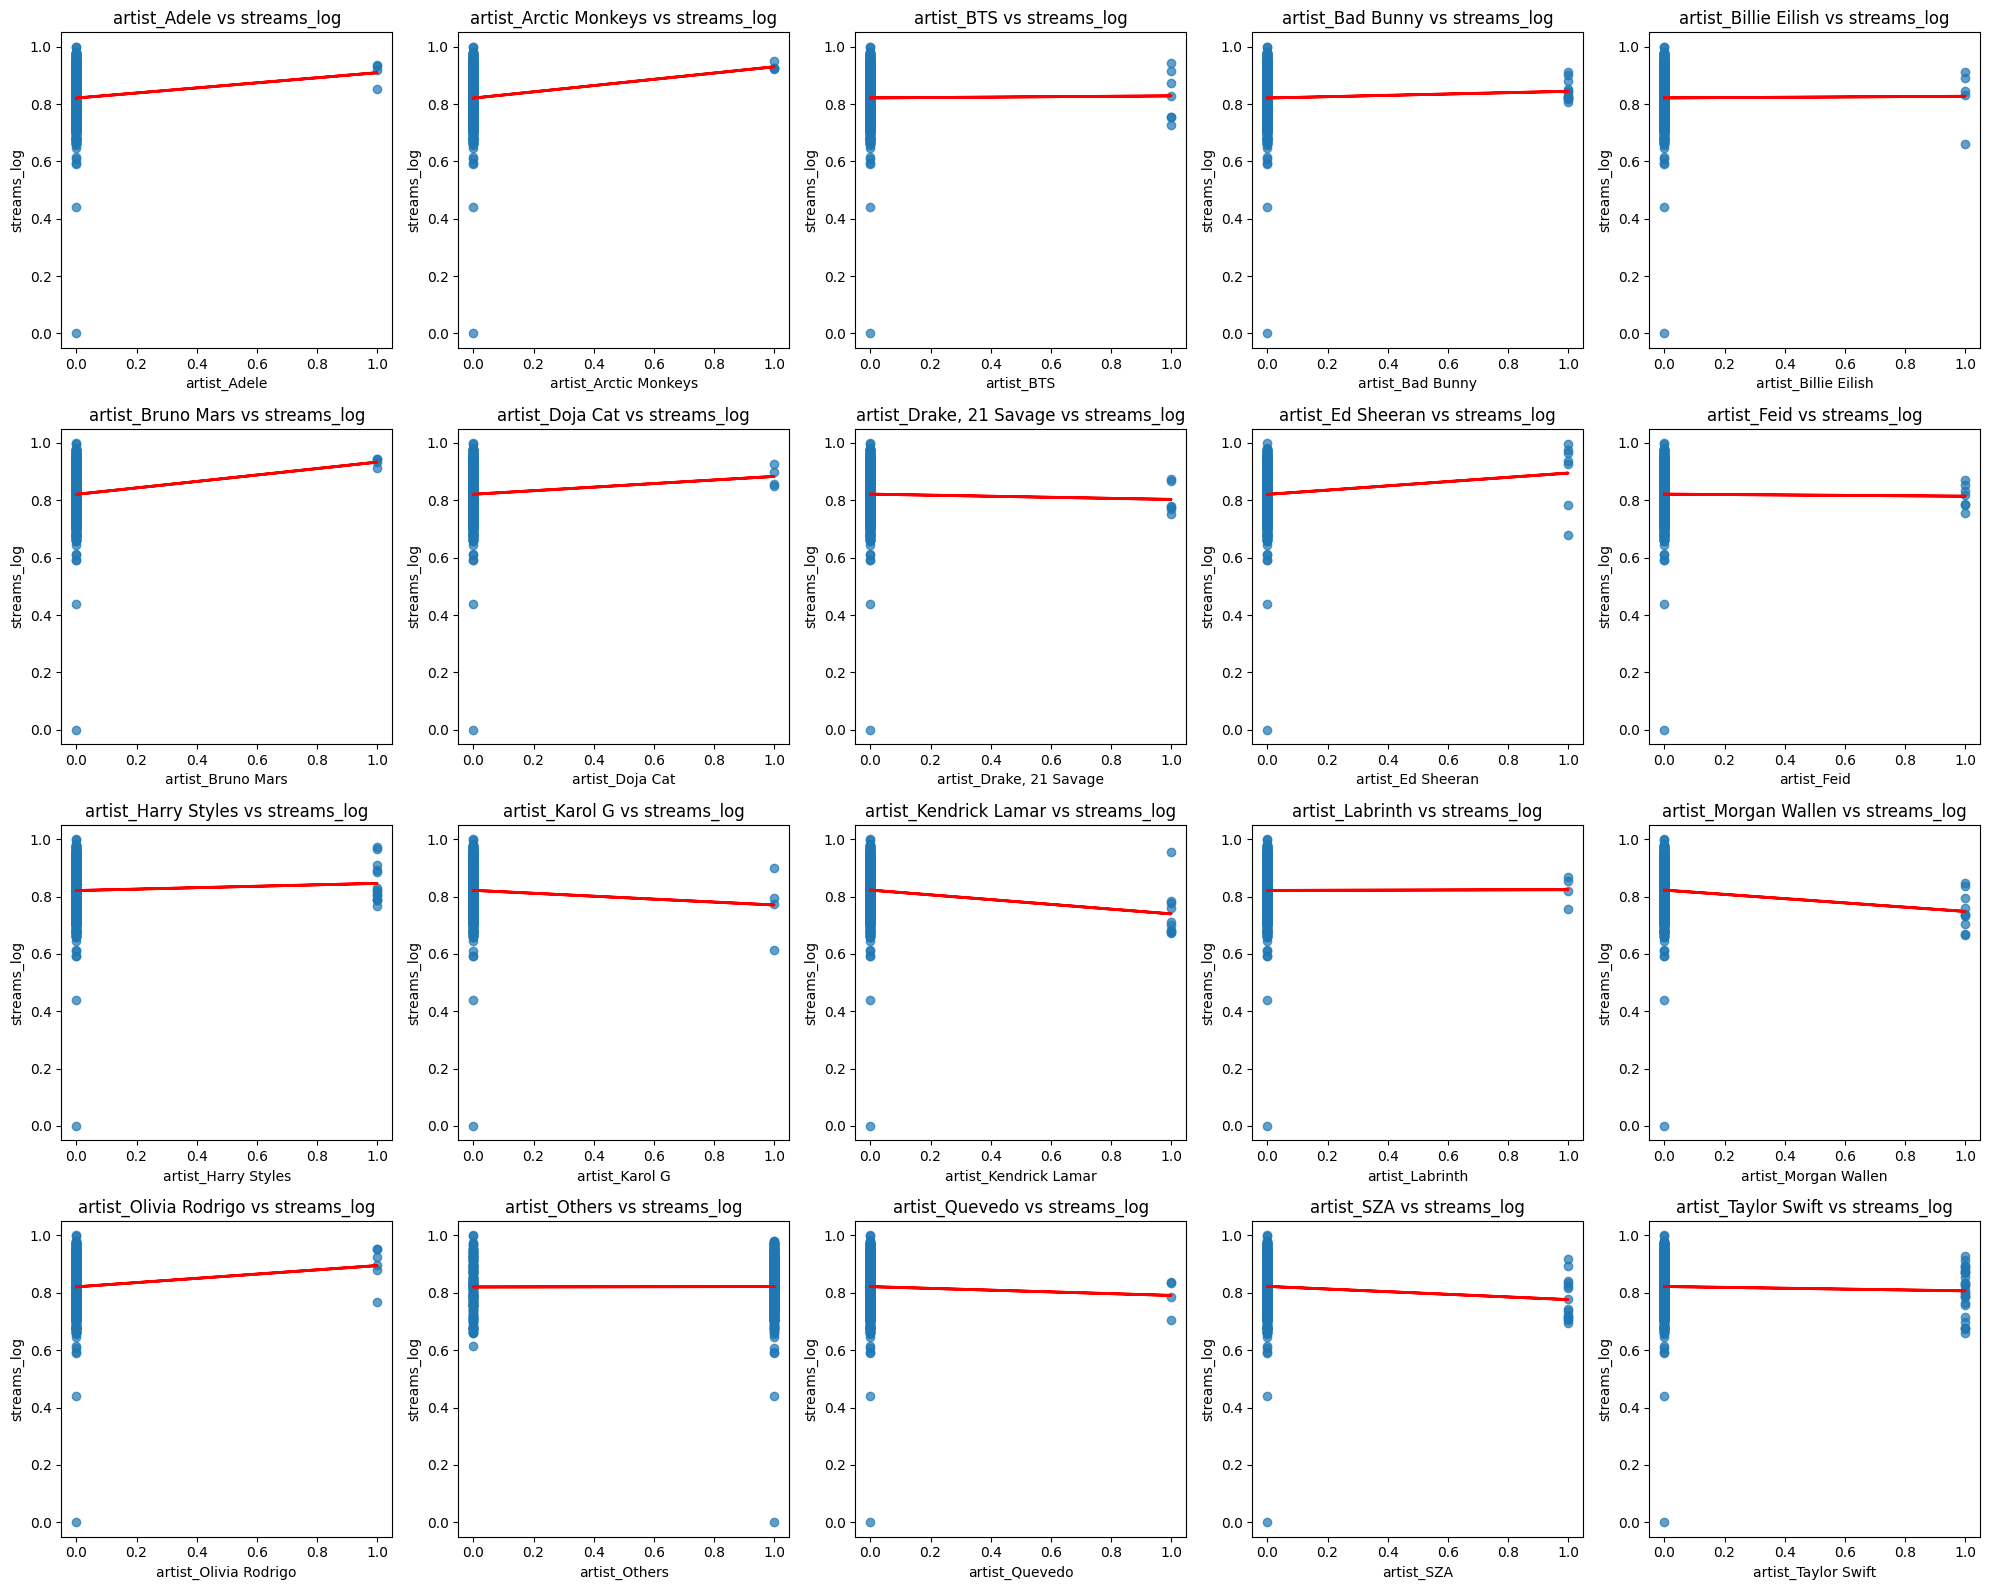

In [348]:
examine_linear(train_df, 'streams_log', train_df.columns[20:40])

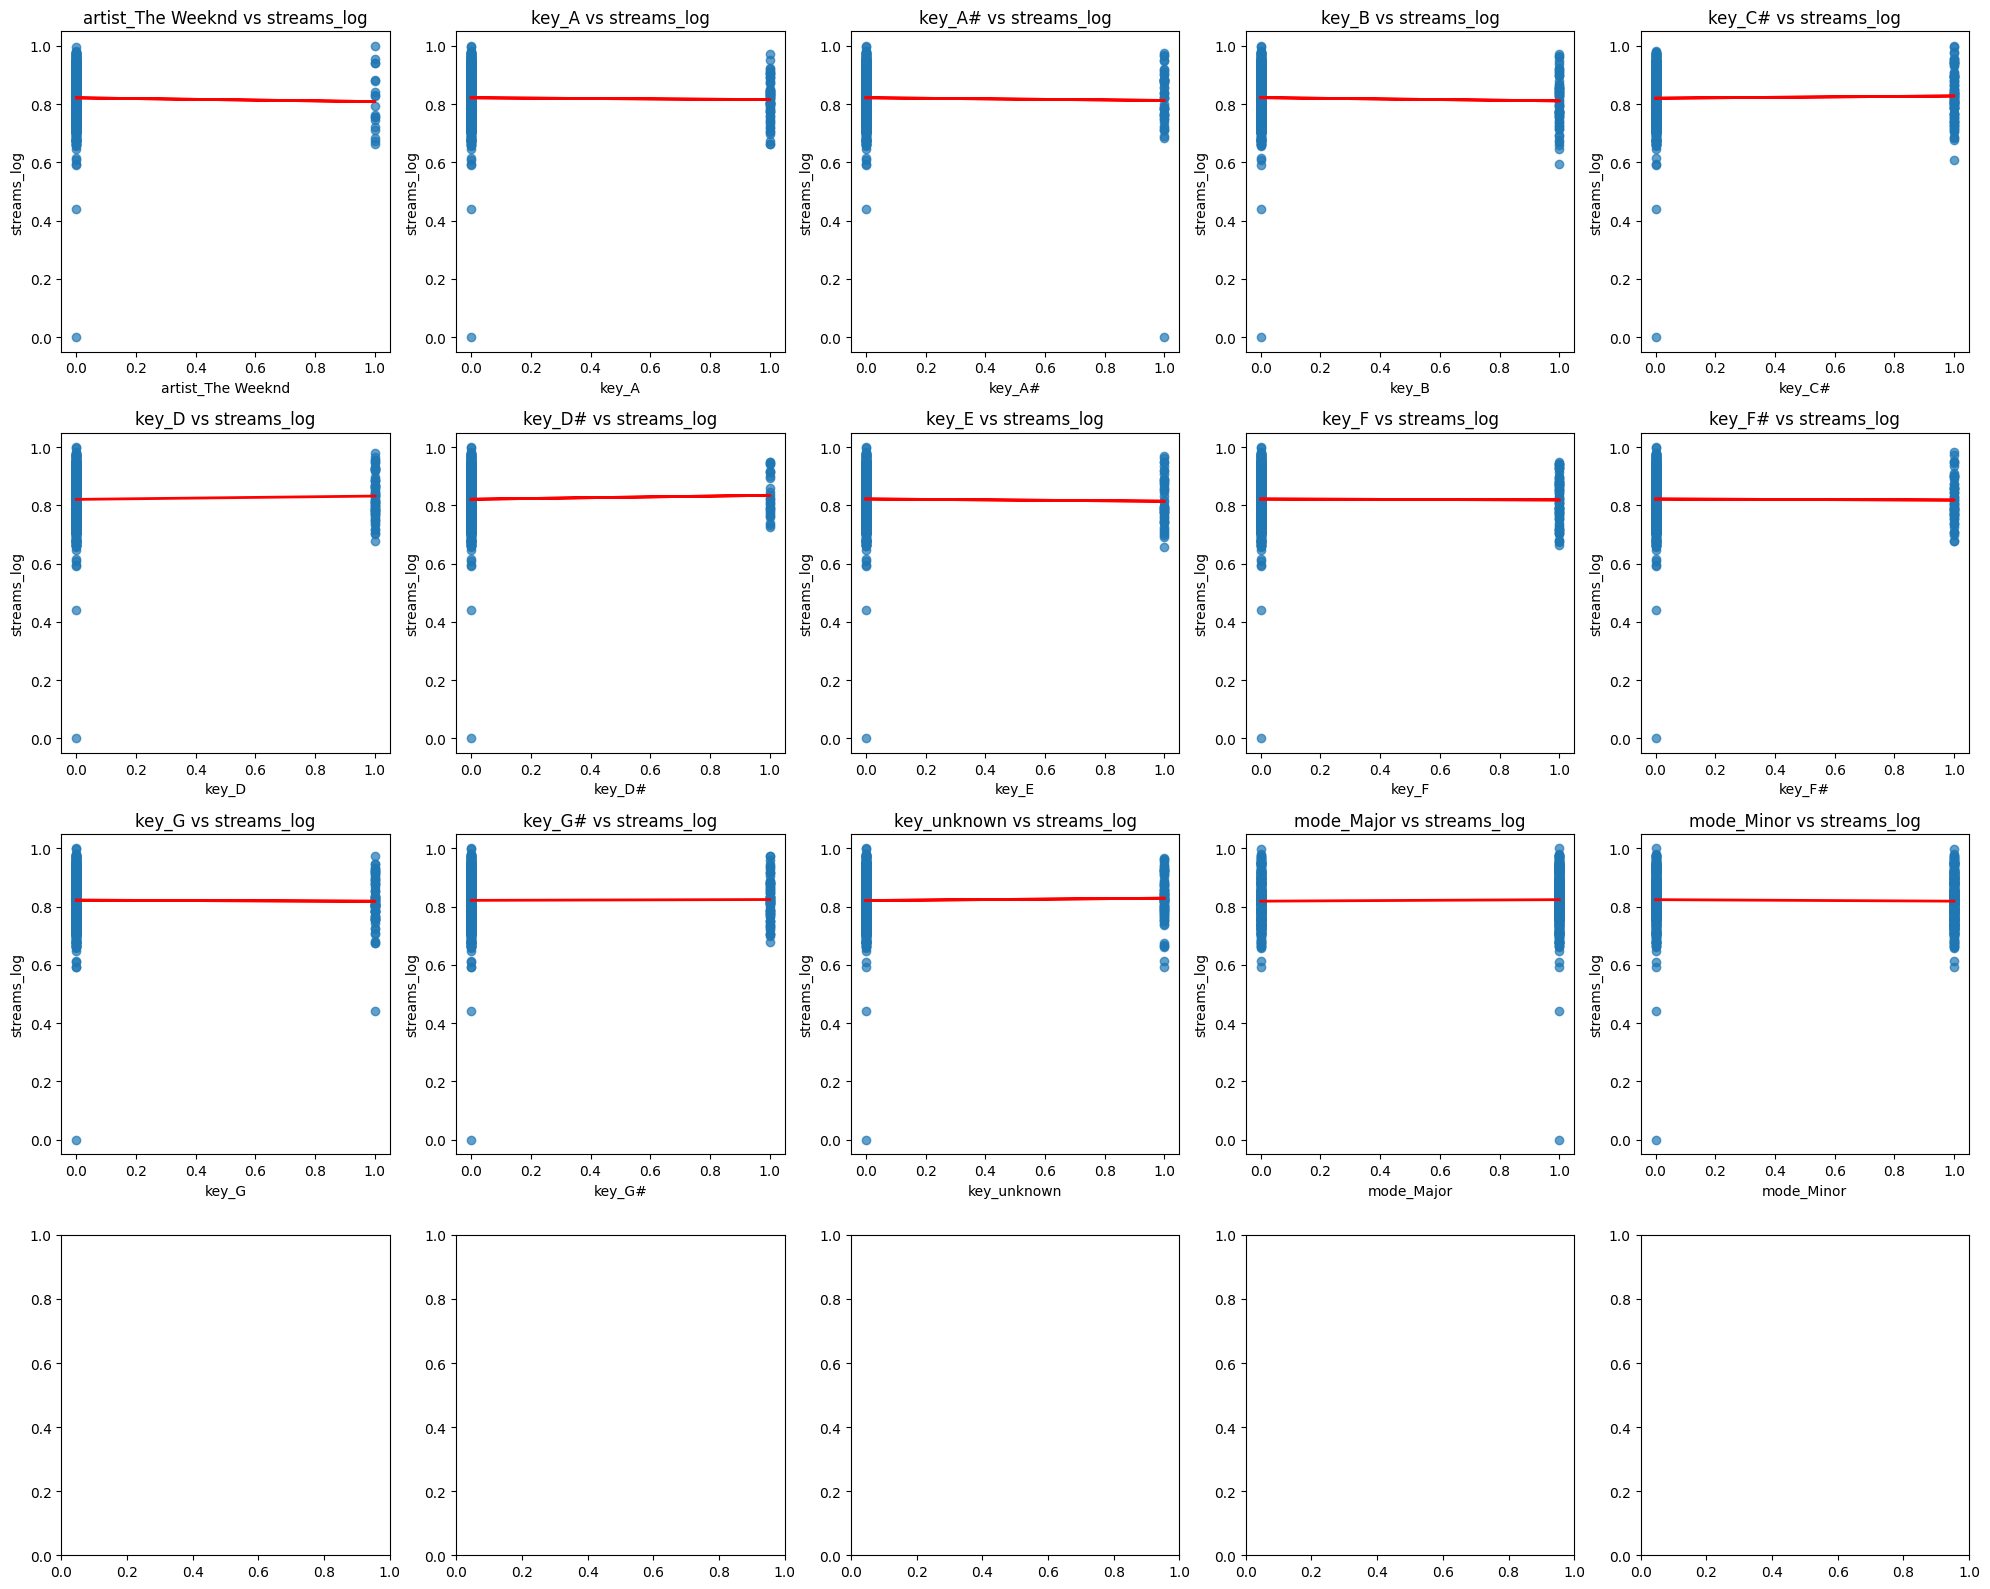

In [349]:
examine_linear(train_df, 'streams_log', train_df.columns[40:55])

In [ ]:
import statsmodels.api as sm

some_cols = train_df.columns[:20].drop([
    'released_month', 'released_day', 'bpm','valence_%',
    'streams', 'energy_%','acousticness_%'
    ])

# 독립변수와 종속변수는 반드시 train_df의 실제 컬럼명으로 바꿀 것

for col in some_cols:
  X = train_df[col]
  y = train_df['streams']

  # 상수항 추가
  X = sm.add_constant(X)

  # OLS 모델 적합
  model = sm.OLS(y, X)
  results = model.fit()
  print(f"{col} vs streams")
  print(results.summary())
  print("\n\n\n")


First, I performed OLS fitting only on several variables whose scatter plot trend lines were not flat. According to the results, all the selected variables are significant at the 0.05 level based on their P-values.

If we evaluate the OLS coefficients, **being included in playlists and charts has the strongest positive impact on a song’s streams. Moreover, it appears that being added to a playlist is more advantageous than being placed on a chart.**

 Considering explanatory power (adjusted R-squared), the only variables that can independently explain the data are **'in_apple_playlists'** and **'in_spotify_playlists'**.

Of course, this should not be the end of the analysis. Naturally, there is likely to be multicollinearity among the independent variables.